In [1]:
import arviz as az
from matplotlib import rc
import matplotlib.pylab as plt
import json

import numpy as np
from scipy.stats import gaussian_kde
from scipy.special import erf
import sys
import glob
from corner import corner

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# General run inspection

Let's start just by inspecting our inference output to make sure that everything is well-behaved!
For reference, we are assuming that the source-frame merger rate density of binary black holes is described by:

\begin{equation}
\frac{dN}{dV_c dt_\mathrm{src} dm_1} = R_\mathrm{pl}(z) P(m_1|\alpha,m_\mathrm{min},m_\mathrm{max})
    + R_\mathrm{peak}(z) N(m_1|\mu_m,\sigma_m),
\end{equation}

where $P(m_1|\alpha,m_\mathrm{min},m_\mathrm{max})$ is a normalized power-law with slope $\alpha$ and cutoffs $m_\mathrm{min}$ and $m_\mathrm{max}$, and $N(m_1|\mu_m,\sigma_m)$ is a normalized Gaussian centered at $\mu_m$ with standard deviation $\sigma_m$. The merger rate densities of each component are allowed to separately evolve as

\begin{equation}
R_\mathrm{pl}(z) = R^0_\mathrm{pl}(1+z)^{\kappa_\mathrm{pl}}
\end{equation}

and

\begin{equation}
R_\mathrm{peak}(z) = R^0_\mathrm{peak}(1+z)^{\kappa_\mathrm{peak}}.
\end{equation}

We assume a power-law distribution of mass ratios, with

\begin{equation}
p(m_2 | m_1) = P(m_2|\beta_q,m_\mathrm{min},m_\mathrm{max}),
\end{equation}

and assume that spins follow their parameter estimation priors (isotropic and uniform in magnitude). We fix the minimum and maximum masses to $m_\mathrm{min} = 5\,M_\odot$ and $m_\mathrm{max} = 100\,M_\odot$.

First let's just look at some summary statistics for the run. Note that the `r` parameters should be close to unity, which indicates run convergence.

In [2]:
data = az.from_netcdf("../output/powerLaw_peak_inVsOutPeak.cdf")
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-3.190,0.391,-3.912,-2.444,0.010,0.007,1536.0,1302.0,1.00
bq,2.065,0.964,0.435,3.958,0.021,0.016,2379.0,1728.0,1.00
kappa_peak,-0.383,1.865,-4.114,2.997,0.054,0.042,1195.0,1324.0,1.00
kappa_pl,0.405,1.755,-2.923,3.590,0.049,0.035,1277.0,1816.0,1.00
log_R0_peak,0.036,0.286,-0.498,0.558,0.009,0.006,1014.0,1388.0,1.01
log_R0_pl,1.315,0.142,1.052,1.579,0.003,0.002,1688.0,1322.0,1.00
min_log_neff,1.532,0.186,1.197,1.851,0.004,0.003,1894.0,2030.0,1.00
mu_m,32.783,3.109,26.407,37.845,0.088,0.062,1424.0,1106.0,1.00
nEff_inj_per_event,5.443,1.470,2.767,8.262,0.030,0.022,2314.0,2343.0,1.00
sig_m,4.010,1.915,1.014,7.353,0.055,0.039,1196.0,1373.0,1.01


Now let's look at the chains themselves.

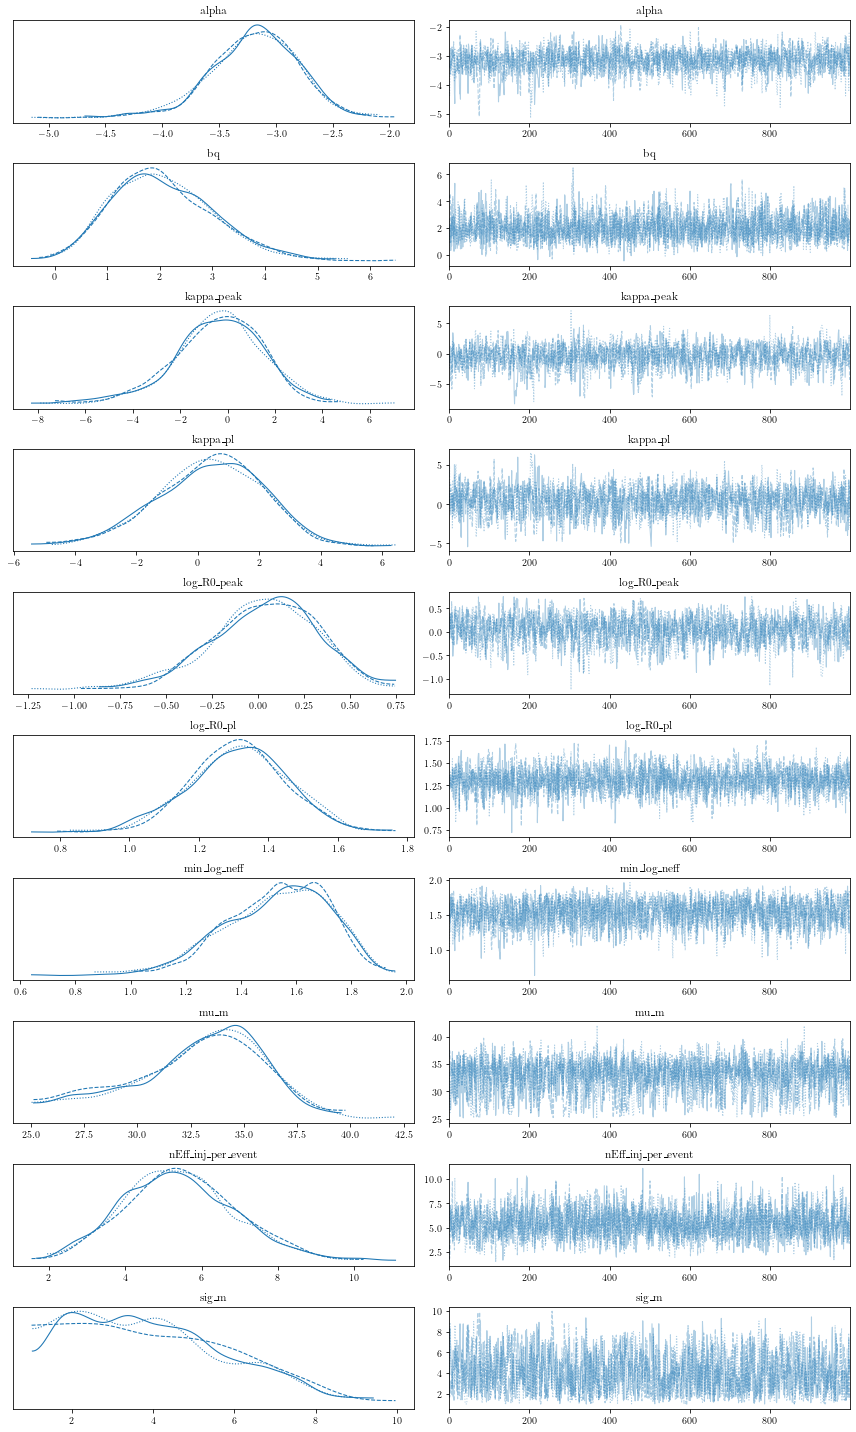

In [3]:
az.plot_trace(data, compact=True)
plt.tight_layout()
plt.show()

Look at a complete corner plot:

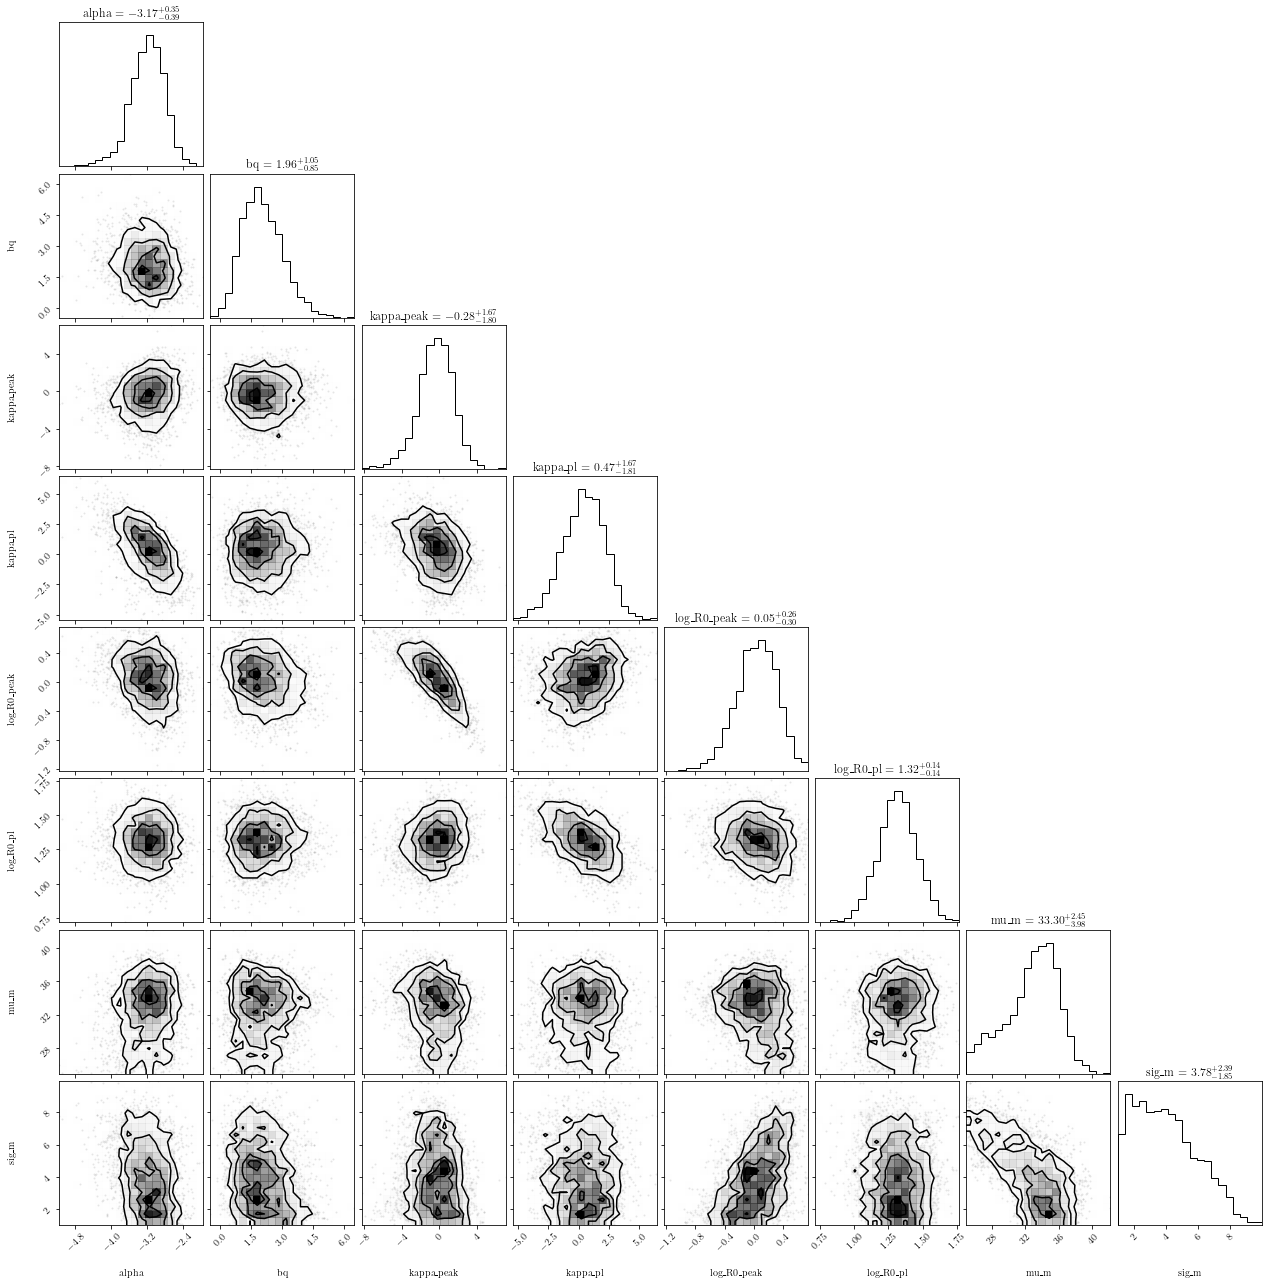

In [4]:
corner(data,show_titles=True,var_names=["alpha","bq","kappa_peak","kappa_pl","log_R0_peak","log_R0_pl","mu_m","sig_m"])
plt.show()

Now combine our chains and specifically look at the two `kappa` values

In [5]:
samples = data.posterior.stack(draws=("chain", "draw"))
kappa_pls = samples.kappa_pl
kappa_peaks = samples.kappa_peak

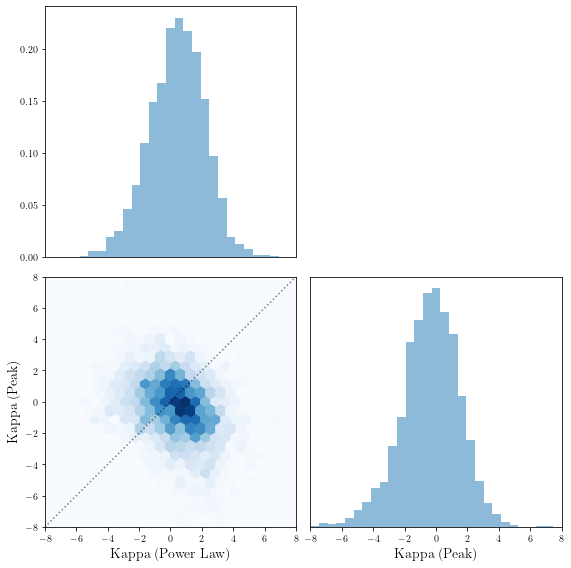

In [6]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(221)
ax.hist(kappa_pls,density=True,bins=np.linspace(-8,8,30),alpha=0.5,label='All')
ax.set_xticks([])
ax.set_xlim(-8,8)

ax = fig.add_subplot(223)
ax.hexbin(kappa_pls,kappa_peaks,gridsize=25,extent=(-8,8,-8,8),cmap='Blues')
ax.plot([-8,8],[-8,8],color='black',alpha=0.5,ls=':')
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_xlabel('Kappa (Power Law)',fontsize=14)
ax.set_ylabel('Kappa (Peak)',fontsize=14)

ax = fig.add_subplot(224)
ax.hist(kappa_peaks,density=True,bins=np.linspace(-8,8,30),alpha=0.5,label='All')
ax.set_yticks([])
ax.set_xlim(-8,8)
ax.set_xlabel('Kappa (Peak)',fontsize=14)

plt.tight_layout()
plt.show()

Print out our constraints:

In [7]:
kappa_pl_95 = np.quantile(kappa_pls,0.95)
kappa_pl_50 = np.quantile(kappa_pls,0.50)
kappa_pl_05 = np.quantile(kappa_pls,0.05)

print("We measure: kappa_pl={0:.1f} (+{1:.1f}/-{2:.1f})".format(kappa_pl_50,
                                                                 kappa_pl_95-kappa_pl_50,
                                                                 kappa_pl_50-kappa_pl_05))

kappa_peak_95 = np.quantile(kappa_peaks,0.95)
kappa_peak_50 = np.quantile(kappa_peaks,0.50)
kappa_peak_05 = np.quantile(kappa_peaks,0.05)

print("We measure: kappa_peak={0:.1f} (+{1:.1f}/-{2:.1f})".format(kappa_peak_50,
                                                                   kappa_peak_95-kappa_peak_50,
                                                                   kappa_peak_50-kappa_peak_05))

percent_pl_greater = 100.*kappa_pls[kappa_pls>kappa_peaks].size/kappa_pls.size
print("kappa_pl is greater than kappa_peak {0:.1f}% of the time".format(percent_pl_greater))

We measure: kappa_pl=0.5 (+2.6/-3.1)
We measure: kappa_peak=-0.3 (+2.7/-3.4)
kappa_pl is greater than kappa_peak 58.5% of the time
